In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline


import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import PolynomialRegression
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

/Users/Adam/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#these files came from http://www.imdb.com/interfaces/
imdb_ratings = pd.read_csv('~/Downloads/title.ratings.tsv',sep='\t')
imdb_titles  = pd.read_csv('~/Downloads/title.basics.tsv' ,sep='\t')

/Users/Adam/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#filter out and clean some titles from imdb_titles
ti=imdb_titles[imdb_titles['isAdult'] ==0].drop(['isAdult'],axis=1) #remove adult movies
ti=ti[ti['startYear']!='\\N']
ti=ti[ti['runtimeMinutes']!='\\N']
ti=ti[ti['startYear']>1990].drop(['endYear'],axis=1)
ti=ti[ti['titleType']=='movie'].drop(['titleType'],axis=1)
ti=ti[ti['primaryTitle']==ti['originalTitle']].drop(['originalTitle'],axis=1)

In [4]:
#merge in the imdb_ratings data on tconst
aaaa = pd.merge(ti,imdb_ratings,left_on='tconst',right_on='tconst')

#clean filter to about ~4000 recent movies with significant voting
aaaa['startYear']=aaaa['startYear'].apply(lambda x: int(x))
aaaa=aaaa[aaaa['numVotes']>10000]
aaaa=aaaa[aaaa['startYear']>2000]

In [5]:
tconsts=aaaa.tconst.tolist()
#results of imdb scraping
imdbScr=pd.read_csv('/Users/Adam/Metis/scrapys/imdb/scrapedall.csv')
imdbScr.rename(columns={'tconst': 'imdbURL'},inplace=True)
imdbScr['tconst']=imdbScr['imdbURL'].str.slice(-10,-1)
imdbScr.shape

(3856, 9)

In [6]:
def str2intornan(s):
    if type(s)==str:
        if 'INR' in s: return float('NaN') #get rid of data not in dollars
        i=''.join(c for c in str(s) if c.isdigit())
        if i=='': i=float('NaN')
        else: i=int(i)
        return i
    else: return s

In [7]:
imdbScr.openingWeekend = imdbScr.openingWeekend.apply(str2intornan)
imdbScr.budget         = imdbScr.budget.apply(str2intornan)
imdbScr.usaGross       = imdbScr.usaGross.apply(str2intornan)
imdbScr.MPAArating     = imdbScr.MPAArating.str.strip('\n')
imdbScr.name           = imdbScr.name.str.strip(' ,').str.replace('\xc2\xa0','')
imdbScr['initialRush'] = imdbScr.openingWeekend / imdbScr.usaGross
imdbScr.runtime        = imdbScr.runtime.str.strip(' min')

imdbScr.head(2)

,ratingIMDB,imdbURL,name,runtime,MPAArating,usaGross,budget,openingWeekend,tconst,initialRush
0,8.8,http://www.imdb.com/title/tt0120737/,The Lord of the Rings: The Fellowship of the Ring,178,PG-13,315544750.0,93000000.0,47211490.0,tt0120737,0.149619
1,6.4,http://www.imdb.com/title/tt0035423/,Kate & Leopold,118,PG-13,47121859.0,48000000.0,2562448.0,tt0035423,0.054379


In [8]:
#results of rotten tomatoes scraping
rtScr=pd.read_csv('/Users/Adam/Metis/scrapys/imdb/scrapedrtall.csv')
rtScr.shape

(2377, 9)

In [9]:
#clean data
rtScr.tmallave       = rtScr.tmallave.str.strip().str.replace('/10','').astype(float)
rtScr.audiencescore  = rtScr.audiencescore.str.strip('%').astype(int)
rtScr.tmtopave       = rtScr.tmtopave.str.strip().str.replace('/10','').astype(float)
rtScr.boxofficeRT    = rtScr.boxofficeRT.str.strip('$').str.replace(',','').apply(str2intornan)#.astype(float)
rtScr.ratingRT       = rtScr.ratingRT.apply(lambda i: str(i).split(' ')[0])
rtScr.runtimeRT      = rtScr.runtimeRT.apply(lambda i: ''.join(c for c in str(i) if c.isdigit()))#.astype(float)
rtScr['titleRT']     = rtScr.url.str.slice(33,-1)
rtScr.rename(columns={'url': 'rtURL'},inplace=True)

rtScr.head(2)

,tmtopave,tmallave,tmall,rtURL,audiencescore,boxofficeRT,tmtop,runtimeRT,ratingRT,titleRT
0,7.7,8.2,91,https://www.rottentomatoes.com/m/the_lord_of_t...,95,314000000.0,93,165,PG-13,the_lord_of_the_rings_the_fellowship_of_the_ring
1,5.0,5.3,50,https://www.rottentomatoes.com/m/kate_and_leop...,62,47095453.0,41,118,PG-13,kate_and_leopold


In [10]:
imdbScr.shape[0],rtScr.shape[0]

(3856, 2377)

In [11]:
#prepare for merge from scrapes
imdbScr['rottenTitle']=imdbScr.name.str.strip(', ').str.lstrip(' ').str.replace(' ','_').str.replace('&','and').str.replace(':','').str.replace('-','').str.replace(',','').str.replace('\'','').str.replace('.','').str.replace('\xc2\xa0','').str.lower()


In [12]:
#merge the scraped data
scrapedData =  pd.merge(imdbScr,rtScr,how='inner',left_on='rottenTitle',right_on='titleRT')
#scrapedData.head()

#merge back in to the original imdb title
data =  pd.merge(aaaa,scrapedData,left_on='tconst',right_on='tconst')
data.drop(['titleRT'],axis=1,inplace=True) #duplicate column

In [13]:
aaaa.shape[0],imdbScr.shape[0],rtScr.shape[0],scrapedData.shape[0],data.shape[0]

(3856, 3856, 2377, 2381, 2381)

In [14]:
oc=data.columns.tolist()
len(oc)

26

In [15]:
#reorder columns based on subject
od=['tconst', 'rtURL', 'imdbURL', 'name',  'rottenTitle', 'primaryTitle', 'startYear', 'genres', 'runtimeMinutes', 'runtime', 'runtimeRT', 'averageRating', 'numVotes',  'tmtopave', 'tmallave', 'tmall', 'audiencescore',  'tmtop','ratingIMDB',   'ratingRT', 'MPAArating',  'usaGross', 'budget', 'openingWeekend', 'initialRush','boxofficeRT']
data=data[od]


In [16]:
data.iloc[:2, -23:]

,name,rottenTitle,primaryTitle,startYear,genres,runtimeMinutes,runtime,runtimeRT,averageRating,numVotes,...,audiencescore,tmtop,ratingIMDB,ratingRT,MPAArating,usaGross,budget,openingWeekend,initialRush,boxofficeRT
0,Kate & Leopold,kate_and_leopold,Kate & Leopold,2001,"Comedy,Fantasy,Romance",118,118,118,6.4,70064,...,62,41,6.4,PG-13,PG-13,47121859.0,48000000.0,2562448.0,0.054379,47095453.0
1,Glitter,glitter,Glitter,2001,"Drama,Music,Romance",104,104,104,2.2,20147,...,45,3,2.2,PG-13,PG-13,4273372.0,22000000.0,2414596.0,0.565033,3865759.0


**Shrink data set**

In [17]:
mvp=data[['name','MPAArating','runtime','audiencescore','ratingIMDB','usaGross','budget','initialRush']]

In [18]:
#data['MPAArating','ratingRT']=data[data.ratingRT!=data.MPAArating]


In [19]:
# data['Rating'][data.ratingRT==data.MPAArating] = data.MPAArating[data.ratingRT==data.MPAArating]
# data['Rating'][data.ratingRT!=data.MPAArating] = data.MPAArating[data.ratingRT!=data.MPAArating]

In [20]:
mvp=mvp.dropna()
mvp.runtime=mvp.runtime.astype(int)

In [21]:
mvp['meantime']=mvp.runtime-mvp.runtime.mean()
mvp.drop('runtime',axis=1)
mvp.drop_duplicates(inplace=True)
mvp=mvp[mvp['initialRush']<0.8] #more than 1 is impossible and indicates bad data
mvp=mvp[mvp['budget']>100000] #oddly small numbers here indicates sketchy data quality
mvp.budget=mvp.budget/100000
mvp=mvp[mvp['usaGross']>100000]
mvp.usaGross = mvp.usaGross/100000
mvp['absmeantime']=mvp.meantime.abs()
mvp.head()

,name,MPAArating,runtime,audiencescore,ratingIMDB,usaGross,budget,initialRush,meantime,absmeantime
0,Kate & Leopold,PG-13,118,62,6.4,471.21859,480.0,0.054379,6.974879,6.974879
1,Glitter,PG-13,104,45,2.2,42.73372,220.0,0.565033,-7.025121,7.025121
2,Fantastic Four,PG-13,106,45,5.7,1546.96080,1000.0,0.362398,-5.025121,5.025121
4,Frida,R,123,85,7.4,258.85000,120.0,0.007958,11.974879,11.974879
6,The Lord of the Rings: The Fellowship of the Ring,PG-13,178,95,8.8,3155.44750,930.0,0.149619,66.974879,66.974879


In [22]:
mvp.sort_values('budget').head(2)

,name,MPAArating,runtime,audiencescore,ratingIMDB,usaGross,budget,initialRush,meantime,absmeantime
485,Beyond the Sea,PG-13,118,64,6.7,63.18709,1.79558,0.007163,6.974879,6.974879
690,Wolf Creek,R,99,49,6.3,161.88180,2.44306,0.303197,-12.025121,12.025121


In [23]:
mvp.dtypes

name              object
MPAArating        object
runtime            int64
audiencescore      int64
ratingIMDB       float64
usaGross         float64
budget           float64
initialRush      float64
meantime         float64
absmeantime      float64
dtype: object

In [24]:
mvp.corr()

,runtime,audiencescore,ratingIMDB,usaGross,budget,initialRush,meantime,absmeantime
runtime,1.000000,0.400385,0.451256,0.321538,0.383855,-0.172460,1.000000,0.418816
audiencescore,0.400385,1.000000,0.833249,0.319502,0.065649,-0.478485,0.400385,0.093825
ratingIMDB,0.451256,0.833249,1.000000,0.265428,0.076592,-0.496025,0.451256,0.123248
usaGross,0.321538,0.319502,0.265428,1.000000,0.632827,-0.006316,0.321538,0.212457
budget,0.383855,0.065649,0.076592,0.632827,1.000000,0.176138,0.383855,0.203338
initialRush,-0.172460,-0.478485,-0.496025,-0.006316,0.176138,1.000000,-0.172460,-0.028522
meantime,1.000000,0.400385,0.451256,0.321538,0.383855,-0.172460,1.000000,0.418816
absmeantime,0.418816,0.093825,0.123248,0.212457,0.203338,-0.028522,0.418816,1.000000


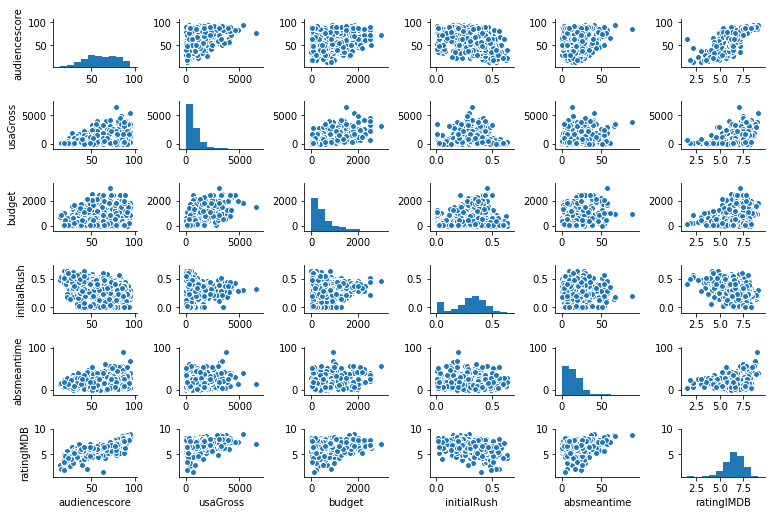

In [25]:
sns.pairplot(mvp.iloc[:,[3,5,6,7,9,4]], size = 1.2, aspect=1.5)

In [26]:
mvp.columns

Index([u'name', u'MPAArating', u'runtime', u'audiencescore', u'ratingIMDB',
       u'usaGross', u'budget', u'initialRush', u'meantime', u'absmeantime'],
      dtype='object')

In [27]:
y=mvp.ratingIMDB
X=mvp[['absmeantime','initialRush','budget','usaGross']]

In [28]:
y.head()

0    6.4
1    2.2
2    5.7
4    7.4
6    8.8
Name: ratingIMDB, dtype: float64

In [29]:
# pick the line that represents what you want to see
#y, X = patsy.dmatrices('ratingIMDB ~ absmeantime + initialRush + budget + usaGross', data=mvp, return_type="dataframe")
y, X = patsy.dmatrices('ratingIMDB ~ absmeantime + initialRush  + budget', data=mvp, return_type="dataframe")
#y, X = patsy.dmatrices('ratingIMDB ~ absmeantime  + budget', data=mvp, return_type="dataframe")
#y, X = patsy.dmatrices('ratingIMDB ~ audiencescore', data=mvp, return_type="dataframe")
#y, X = patsy.dmatrices('ratingIMDB ~ initialRush', data=mvp, return_type="dataframe")
#y, X = patsy.dmatrices('ratingIMDB ~ absmeantime', data=mvp, return_type="dataframe")


# Create and fit model
model = sm.OLS(y, X)
fit = model.fit()

#summary
i=fit.params
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             ratingIMDB   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     126.5
Date:                Sun, 28 Jan 2018   Prob (F-statistic):           3.20e-69
Time:                        17:57:13   Log-Likelihood:                -1227.7
No. Observations:                 982   AIC:                             2463.
Df Residuals:                     978   BIC:                             2483.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       7.2824      0.073     99.844      0.000       7.139       7.426
absmeantime     0.0069      0.002      2.785      0.005       0.002       0.012
initialRush    -3.6335      0.193    -18.842      0.000      -4.012      -3.255
budget          0.0003   5.44e-05      5.408      0.000       0.000       0.000
==============================================================================
Omnibus:                      135.304   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              278.099
Skew:                          -0.810   Prob(JB):                     4.09e-61
Kurtosis:                       5.043   Cond. No.                     5.65e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.65e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
# import statsmodels.graphics.regressionplots
# statsmodels.graphics.regressionplots.plot_fit(fit,'absmeantime')

In [31]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

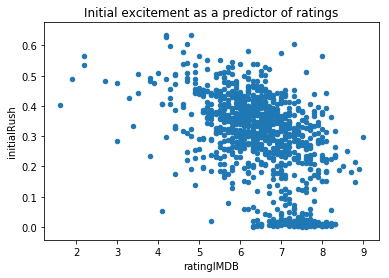

In [32]:
fig,ax=plt.subplots(1,1)
mvp.plot('ratingIMDB','initialRush',kind='scatter',ax=ax,title='Initial excitement as a predictor of ratings')
#plt.plot(a,b,'r');

In [33]:
# Create an empty model
#lr = LinearRegression()
est = make_pipeline(PolynomialFeatures(2),LinearRegression())

# Choose the predictor variables, here all but the first which is the response variable
# This model is analogous to the Y ~ X1 + X2 + X3 + X4 + X5 + X6 model
X = mvp.iloc[:, [5,6,7,9]]
# Choose the response variable(s)
y = mvp.iloc[:, 4]
# Fit the model to the full dataset
est.fit(X, y)
# Print out the R^2 for the model against the full dataset
est.score(X,y)
#est.predict(X,y)

0.34251560174291396

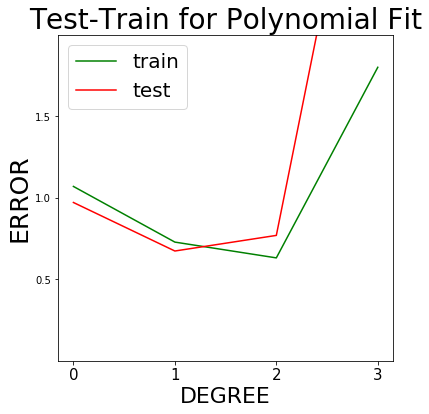

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
X = mvp.iloc[:, [5,6,7,9]]
y = mvp.iloc[:, 4]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)
from sklearn.metrics import mean_squared_error

dr=4
# Step through degrees from 0 to 9 and store the training and test (generalization) error.
train_error = np.empty(dr)
test_error = np.empty(dr)
for degree in range(dr):
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(X_train, y_train)
    train_error[degree] = mean_squared_error(y_train, est.predict(X_train))
    test_error[degree] = mean_squared_error(y_test, est.predict(X_test))

# Plot the training and test errors against degree
plt.figure(figsize=(6,6))
plt.plot(np.arange(dr), train_error, color='green', label='train')
plt.plot(np.arange(dr), test_error, color='red', label='test');
plt.ylim((0.0, 2))
plt.xticks([0,1,2,3],fontsize=15)
plt.yticks([0.5,1,1.5],fontsize=10)
plt.ylabel('ERROR',fontsize=25)#'log(mean squared error)')
plt.xlabel('DEGREE',fontsize=22)
plt.title('Test-Train for Polynomial Fit',fontsize=28)
plt.legend(loc=2,fontsize=20);

In [35]:
from sklearn.linear_model import RidgeCV
rcv = RidgeCV(cv=5,alphas=[0.1,1,10])

X = mvp.iloc[:, [5,6,7,9]]
y = mvp.iloc[:, 4]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7)


rcv.fit(X_train, y_train)
rcv.score(X_test, y_test)

0.28372322809779227

In [36]:
mvp.columns

Index([u'name', u'MPAArating', u'runtime', u'audiencescore', u'ratingIMDB',
       u'usaGross', u'budget', u'initialRush', u'meantime', u'absmeantime'],
      dtype='object')

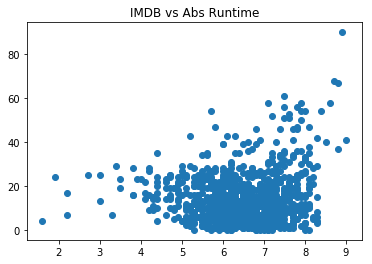

In [37]:
plt.scatter(mvp.iloc[:, 4],mvp.iloc[:, 9]) #for appendix
plt.title("IMDB vs Abs Runtime");


In [38]:
mvp.columns

Index([u'name', u'MPAArating', u'runtime', u'audiencescore', u'ratingIMDB',
       u'usaGross', u'budget', u'initialRush', u'meantime', u'absmeantime'],
      dtype='object')

In [39]:
data.columns

Index([u'tconst', u'rtURL', u'imdbURL', u'name', u'rottenTitle',
       u'primaryTitle', u'startYear', u'genres', u'runtimeMinutes', u'runtime',
       u'runtimeRT', u'averageRating', u'numVotes', u'tmtopave', u'tmallave',
       u'tmall', u'audiencescore', u'tmtop', u'ratingIMDB', u'ratingRT',
       u'MPAArating', u'usaGross', u'budget', u'openingWeekend',
       u'initialRush', u'boxofficeRT'],
      dtype='object')

In [40]:
mvp.head()

,name,MPAArating,runtime,audiencescore,ratingIMDB,usaGross,budget,initialRush,meantime,absmeantime
0,Kate & Leopold,PG-13,118,62,6.4,471.21859,480.0,0.054379,6.974879,6.974879
1,Glitter,PG-13,104,45,2.2,42.73372,220.0,0.565033,-7.025121,7.025121
2,Fantastic Four,PG-13,106,45,5.7,1546.96080,1000.0,0.362398,-5.025121,5.025121
4,Frida,R,123,85,7.4,258.85000,120.0,0.007958,11.974879,11.974879
6,The Lord of the Rings: The Fellowship of the Ring,PG-13,178,95,8.8,3155.44750,930.0,0.149619,66.974879,66.974879


In [41]:
i

Intercept      7.282378
absmeantime    0.006874
initialRush   -3.633507
budget         0.000294
dtype: float64

Finished EDA. ready to apply methods to different columns for real

In [42]:
data.head()

,tconst,rtURL,imdbURL,name,rottenTitle,primaryTitle,startYear,genres,runtimeMinutes,runtime,...,audiencescore,tmtop,ratingIMDB,ratingRT,MPAArating,usaGross,budget,openingWeekend,initialRush,boxofficeRT
0,tt0035423,https://www.rottentomatoes.com/m/kate_and_leop...,http://www.imdb.com/title/tt0035423/,Kate & Leopold,kate_and_leopold,Kate & Leopold,2001,"Comedy,Fantasy,Romance",118,118,...,62,41,6.4,PG-13,PG-13,47121859.0,48000000.0,2562448.0,0.054379,47095453.0
1,tt0118589,https://www.rottentomatoes.com/m/glitter/,http://www.imdb.com/title/tt0118589/,Glitter,glitter,Glitter,2001,"Drama,Music,Romance",104,104,...,45,3,2.2,PG-13,PG-13,4273372.0,22000000.0,2414596.0,0.565033,3865759.0
2,tt0120667,https://www.rottentomatoes.com/m/fantastic_four/,http://www.imdb.com/title/tt0120667/,Fantastic Four,fantastic_four,Fantastic Four,2005,"Action,Adventure,Family",106,106,...,45,30,5.7,PG-13,PG-13,154696080.0,100000000.0,56061504.0,0.362398,154485963.0
3,tt0120667,https://www.rottentomatoes.com/m/fantastic_four/,http://www.imdb.com/title/tt0120667/,Fantastic Four,fantastic_four,Fantastic Four,2005,"Action,Adventure,Family",106,106,...,45,30,5.7,PG-13,PG-13,154696080.0,100000000.0,56061504.0,0.362398,154485963.0
4,tt0120679,https://www.rottentomatoes.com/m/frida/,http://www.imdb.com/title/tt0120679/,Frida,frida,Frida,2002,"Biography,Drama,Romance",123,123,...,85,66,7.4,nan,R,25885000.0,12000000.0,205996.0,0.007958,NaN


In [43]:
data.columns

Index([u'tconst', u'rtURL', u'imdbURL', u'name', u'rottenTitle',
       u'primaryTitle', u'startYear', u'genres', u'runtimeMinutes', u'runtime',
       u'runtimeRT', u'averageRating', u'numVotes', u'tmtopave', u'tmallave',
       u'tmall', u'audiencescore', u'tmtop', u'ratingIMDB', u'ratingRT',
       u'MPAArating', u'usaGross', u'budget', u'openingWeekend',
       u'initialRush', u'boxofficeRT'],
      dtype='object')

In [44]:
data['absmeantime']=data.runtimeMinutes.astype(int)-data.runtimeMinutes.dropna().astype(int).mean()
data['absmeantime']=data.absmeantime.abs()
Data = data[['name','genres','MPAArating','absmeantime','usaGross', 'budget',
       'initialRush','averageRating','tmtopave','tmallave','tmall','audiencescore','tmtop']]
Data.set_index('name',inplace=True)
Data.drop_duplicates(inplace=True)
Data=Data[Data['initialRush']<0.8] #more than 1 is impossible and indicates bad data
Data=Data[Data['budget']>100000] #oddly small numbers here indicates sketchy data quality
Data.budget=Data.budget/100000 #scale
Data=Data[Data['usaGross']>100000] #oddly small numbers here indicates sketchy data quality
Data.usaGross = Data.usaGross/100000 #scale
Data.averageRating*=10
Data.tmtopave*=10
Data.tmallave*=10

Data.head(2)

/Users/Adam/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,genres,MPAArating,absmeantime,usaGross,budget,initialRush,averageRating,tmtopave,tmallave,tmall,audiencescore,tmtop
name,,,,,,,,,,,,
Kate & Leopold,"Comedy,Fantasy,Romance",PG-13,10.830323,471.21859,480.0,0.054379,64.0,50.0,53.0,50,62,41
Glitter,"Drama,Music,Romance",PG-13,3.169677,42.73372,220.0,0.565033,22.0,27.0,28.0,7,45,3


In [45]:
Data.corr()

,absmeantime,usaGross,budget,initialRush,averageRating,tmtopave,tmallave,tmall,audiencescore,tmtop
absmeantime,1.000000,0.156311,0.285553,-0.047095,0.168460,0.121675,0.137452,0.111970,0.151535,0.104300
usaGross,0.156311,1.000000,0.443261,0.088173,0.178078,0.144756,0.161398,0.161397,0.205207,0.141729
budget,0.285553,0.443261,1.000000,0.112566,0.068273,-0.013948,0.007581,-0.022434,0.051291,-0.043228
initialRush,-0.047095,0.088173,0.112566,1.000000,-0.422207,-0.460190,-0.460345,-0.433666,-0.408340,-0.437173
averageRating,0.168460,0.178078,0.068273,-0.422207,1.000000,0.732399,0.774672,0.725441,0.814675,0.682056
tmtopave,0.121675,0.144756,-0.013948,-0.460190,0.732399,1.000000,0.963772,0.938023,0.686451,0.948056
tmallave,0.137452,0.161398,0.007581,-0.460345,0.774672,0.963772,1.000000,0.975981,0.729244,0.941601
tmall,0.111970,0.161397,-0.022434,-0.433666,0.725441,0.938023,0.975981,1.000000,0.716865,0.962539
audiencescore,0.151535,0.205207,0.051291,-0.408340,0.814675,0.686451,0.729244,0.716865,1.000000,0.685994
tmtop,0.104300,0.141729,-0.043228,-0.437173,0.682056,0.948056,0.941601,0.962539,0.685994,1.000000


In [46]:
Data.columns

Index([u'genres', u'MPAArating', u'absmeantime', u'usaGross', u'budget',
       u'initialRush', u'averageRating', u'tmtopave', u'tmallave', u'tmall',
       u'audiencescore', u'tmtop'],
      dtype='object')

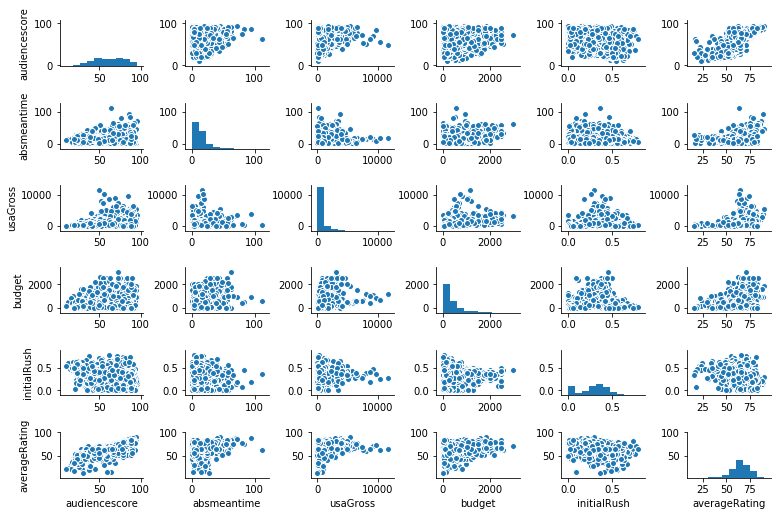

In [47]:
sns.pairplot(Data.iloc[:,[10,2,3,4,5,6]], size = 1.2, aspect=1.5)

In [48]:
#Data.columns
Data.groupby('MPAArating').groups.keys()

['G', 'NC-17', 'PG-13', 'R', 'Not Rated', 'PG']

Make 6 part graph on initial analysis

In [49]:
ys= ['averageRating', 'tmtopave', 'tmallave','audiencescore', 'tmtop', 'tmall']
cs= []
for tar in ys:
    # Create your feature matrix (X) and target vector (y)
    #tar = 'averageRating'
    #y, X = patsy.dmatrices(tar + ' ~ absmeantime + initialRush + budget + usaGross', data=Data, return_type="dataframe")
    #y, X = patsy.dmatrices(tar + ' ~ absmeantime + initialRush  + usaGross', data=Data, return_type="dataframe")
    y, X = patsy.dmatrices(tar + ' ~ absmeantime + initialRush  + usaGross', data=Data, return_type="dataframe")


    # Create  model
    model = sm.OLS(y, X)
    # Fit your model to your training set
    fit = model.fit()
    # Print summary statistics of the model's performance
    i=fit.params
    cs.append([i[0],i[2]])
    #fit.summary()

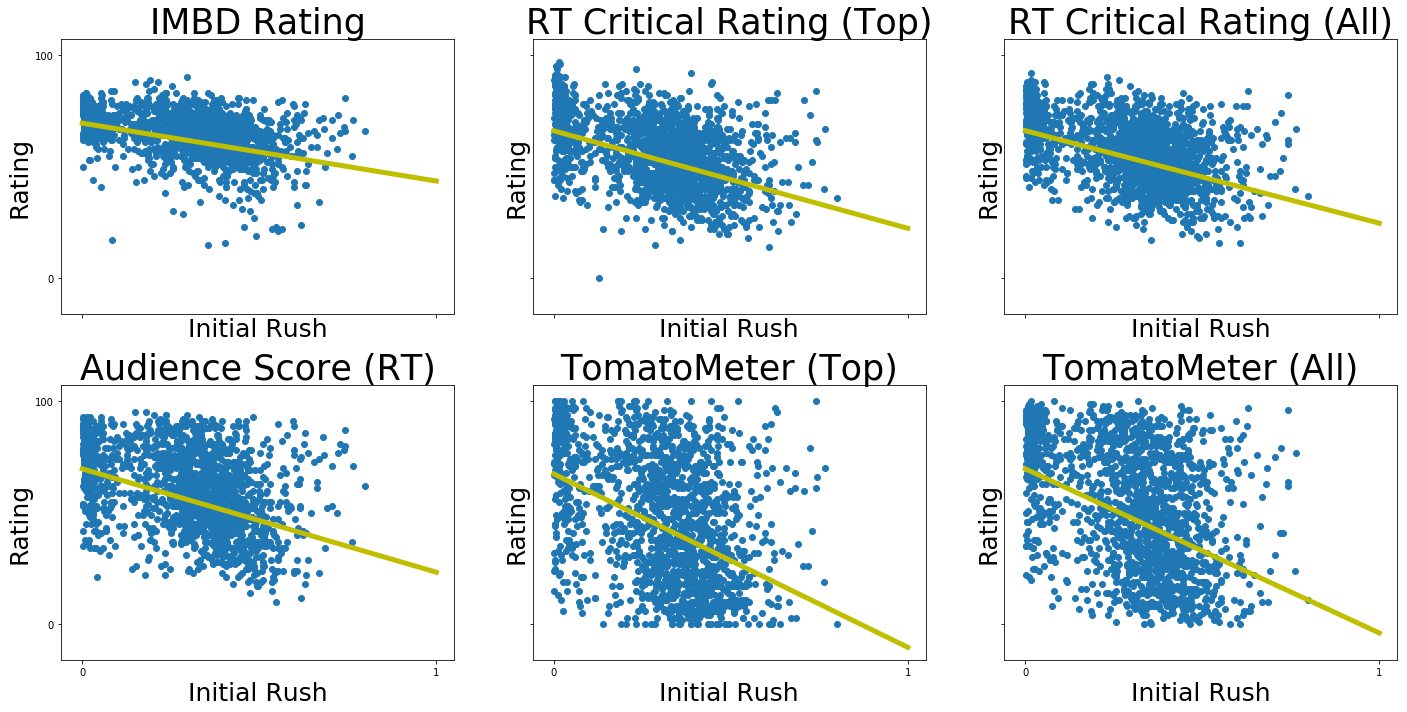

In [50]:
ytitle= ['IMBD Rating', 'RT Critical Rating (Top)', 'RT Critical Rating (All)', 'Audience Score (RT)',  'TomatoMeter (Top)', 'TomatoMeter (All)']

x=Data.initialRush
f, ax = plt.subplots(2, 3, sharey=True,sharex=True,figsize=(20,10))
axs=[(0,0),(0,1),(0,2),(1,0),(1,1),(1,2)]
for i in range(len(ys)):
    ax[axs[i]].scatter(x, Data[ys[i]])
    ax[axs[i]].plot(np.linspace(0,1,100),cs[i][0]+cs[i][1]*np.linspace(0,1,100),'y',linewidth=5)
    plt.plot()
    ax[axs[i]].set_title(ytitle[i],fontsize=35)
    ax[axs[i]].set_ylabel('Rating',fontsize=25)
    ax[axs[i]].set_yticks([0,100])
    ax[axs[i]].set_xticks([0,1])

    ax[axs[i]].set_xlabel('Initial Rush',fontsize=25)
    #ax[axs[i]].legend(['Trend'],fontsize=15,loc=1)

plt.tight_layout();

Make 4 part graph for secondary analysis

In [51]:
gdata=Data[Data.columns]

In [52]:
gdata['PG13']=gdata.MPAArating=='PG-13'
gdata['PG13']=gdata['PG13'].apply(int)
gdata['R']= (gdata.MPAArating == 'R') | (gdata.MPAArating=='NC-17')
gdata['R']=gdata['R'].apply(int)
gdata['PG']=gdata.MPAArating=='PG'
gdata['PG']=gdata['PG'].apply(int)
gdata['G']=gdata.MPAArating=='G'
gdata['G']=gdata['G'].apply(int)
gdata['NR']=gdata.MPAArating=='G'
gdata['NR']=gdata['NR'].apply(int)

In [53]:
gdata.groupby('MPAArating').groups.keys()

['G', 'NC-17', 'PG-13', 'R', 'Not Rated', 'PG']

In [54]:
gdata.columns

Index([u'genres', u'MPAArating', u'absmeantime', u'usaGross', u'budget',
       u'initialRush', u'averageRating', u'tmtopave', u'tmallave', u'tmall',
       u'audiencescore', u'tmtop', u'PG13', u'R', u'PG', u'G', u'NR'],
      dtype='object')

In [55]:
ys= ['averageRating', 'tmtopave','audiencescore', 'tmtop'] #drop top vs all since they weren't statistically different
cs= []
#rs= []
for tar in ys:
    # Create your feature matrix (X) and target vector (y)
    y, X = patsy.dmatrices(tar + ' ~ absmeantime + initialRush  + usaGross +PG13+PG+G+NR', data=gdata, return_type="dataframe")


    # Create  model
    model = sm.OLS(y, X)
    # Fit model to your training set
    fit = model.fit()
    # Print summary statistics of the model's performance
    cs.append(fit.params.tolist())
    #rs.append(fit.rsquared)
    #fit.summary()

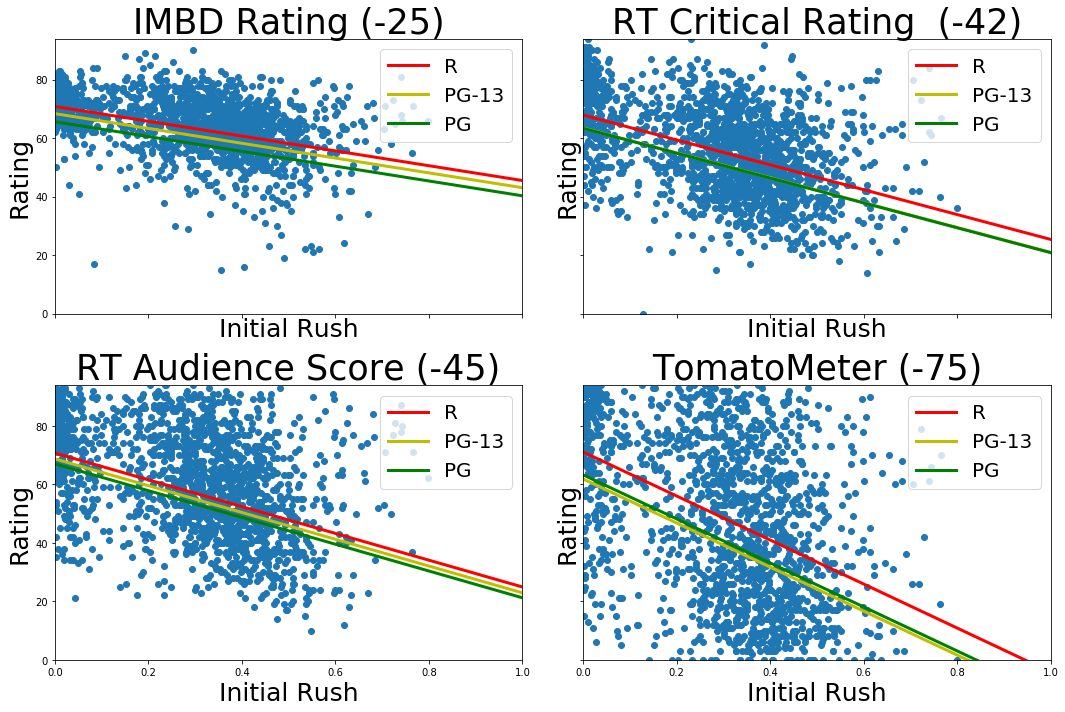

In [56]:
ytitle= ['IMBD Rating', 'RT Critical Rating ', 'RT Audience Score',  'TomatoMeter']

x=gdata.initialRush
f, ax = plt.subplots(2, 2, sharey=True,sharex=True,figsize=(15,10))
axs=[(0,0),(0,1),(1,0),(1,1)]
for i in range(len(ys)):
    ax[axs[i]].scatter(x, gdata[ys[i]])
    
    ax[axs[i]].plot(np.linspace(0,1,100),cs[i][0]+cs[i][2]*np.linspace(0,1,100),'r',label='R',linewidth=3)
    ax[axs[i]].plot(np.linspace(0,1,100),cs[i][0]+cs[i][4]+cs[i][2]*np.linspace(0,1,100),'y',label='PG-13',linewidth=3)
    ax[axs[i]].plot(np.linspace(0,1,100),cs[i][0]+cs[i][5]+cs[i][2]*np.linspace(0,1,100),'g',label='PG',linewidth=3)

    ax[axs[i]].set_ylim(0)
    ax[axs[i]].set_xlim(0,1)

    ax[axs[i]].set_title(ytitle[i]+' ('+str(int(cs[i][2]))+')',fontsize=35)
    ax[axs[i]].set_ylabel('Rating',fontsize=25)
    ax[axs[i]].set_xlabel('Initial Rush',fontsize=25)
    ax[axs[i]].legend(['R','PG-13','PG'],fontsize=20,loc=1)

plt.tight_layout()